In [1]:
# import the libraries

import numpy as np
import pandas as pd
import statsmodels
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import coint   # use this library to find this out the p_value
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import datetime

In [2]:
# predefined functions in this cell ,  no need to chagne them

def downloadStockData(tickers,start,end):
    ticker_data = pdr.get_data_yahoo(tickers, start, end)['Adj Close']
    return ticker_data


In [3]:
tickers = ['HD', 'DIS','MSFT', 'BA', 'MMM', 'PFE', 'NKE', 'JNJ', 'MCD', 'XOM', 'GS', 'JPM', 'AXP', 'V', 'IBM', 'UNH', 'PG', 'GE', 'KO', 'CSCO', 'CVX', 'CAT', 'MRK', 'WMT', 'VZ', 'RTX', 'TRV', 'AAPL', 'ADBE', 'EBAY', 'QCOM', 'HPQ', 'JNPR', 'AMD']
start = datetime.datetime(2011,1,1)
end = datetime.datetime(2013,1,1)
data = downloadStockData(tickers,start,end)

In [124]:
def trade1(data1, data2, window=5 ,MAX_SHORTING_AMOUNT=10000, MAX_TRANSACTION_AT_A_TIME=5,c1=1,c2=0.75):
   
    share1, money, share2, day, nos = 0, MAX_SHORTING_AMOUNT, 0, 0, 0
    ratio = (data1 - data1.mean())/data1.std() / (data2 - data2.mean())/data2.std()
    l1, l2, l3, l4 = ratio.mean() + c1*ratio.std(), ratio.mean() + c2*ratio.std(), ratio.mean() - c2*ratio.std(), ratio.mean() - c1*ratio.std()
    for i in range(1, len(ratio)):
        if day == window:
            money = money + share1*data1[i] + share2*data2[i]
            share1, share2, day, nos = 0, 0, 0, 0
        if ratio[i] >= l1 and ratio[i-1] < l1 and nos<MAX_TRANSACTION_AT_A_TIME:
            amount_available =  (MAX_SHORTING_AMOUNT//((MAX_TRANSACTION_AT_A_TIME )))
            share1 -= amount_available//data1[i]
            share2 += amount_available//data2[i]
            money = money - (share1*data1[i] +share2*data2[i])
            nos += 1
        elif ratio[i-1] >l2 and ratio[i] <=l2 and nos<MAX_TRANSACTION_AT_A_TIME:
            money = money + share1*data1[i] + share2*data2[i]
            share1, share2 = 0, 0
        elif ratio[i-1]<l3 and ratio[i]>=l3 and nos < MAX_TRANSACTION_AT_A_TIME:
            money = money + share1*data1[i] + share2*data2[i]
            share1, share2 = 0, 0
        elif ratio[i-1]>l4 and ratio[i]<=l4 and nos < MAX_TRANSACTION_AT_A_TIME:
            amount_available =  (MAX_SHORTING_AMOUNT//((MAX_TRANSACTION_AT_A_TIME)))
            share1 += amount_available//data1[i]
            share2 -= amount_available//data2[i]
            money = money - (share1*data1[i] +share2*data2[i])
            nos += 1
        day += 1
    return money - MAX_SHORTING_AMOUNT
            

In [125]:
def trade2(data1, data2, window = 5,MAX_SHORTING_AMOUNT=10000, MAX_TRANSACTION_AT_A_TIME=5,c1=1,c2=0.75):
   
    share1, money, share2, day, nos = 0, MAX_SHORTING_AMOUNT, 0, 0, 0
    ratio = (data1 - data1.mean())/data1.std() - (data2 - data2.mean())/data2.std()
    l1, l2, l3, l4 = ratio.mean() + c1*ratio.std(), ratio.mean() + c2*ratio.std(), ratio.mean() - c2*ratio.std(), ratio.mean() - c1*ratio.std()
    for i in range(1, len(ratio)):
        if day == window:
            money = money + share1*data1[i] + share2*data2[i]
            share1, share2, day, nos = 0, 0, 0, 0
        if ratio[i] >= l1 and ratio[i-1] < l1 and nos<MAX_TRANSACTION_AT_A_TIME:
            amount_available =  (MAX_SHORTING_AMOUNT//((MAX_TRANSACTION_AT_A_TIME)))
            share1 -= amount_available//data1[i]
            share2 += amount_available//data2[i]
            money = money - (share1*data1[i] +share2*data2[i])
            nos += 1
        elif ratio[i-1] >l2 and ratio[i] <=l2 and nos<MAX_TRANSACTION_AT_A_TIME:
            money = money + share1*data1[i] + share2*data2[i]
            share1, share2 = 0, 0
        elif ratio[i-1]<l3 and ratio[i]>=l3 and nos < MAX_TRANSACTION_AT_A_TIME:
            money = money + share1*data1[i] + share2*data2[i]
            share1, share2 = 0, 0
        elif ratio[i-1]>l4 and ratio[i]<=l4 and nos < MAX_TRANSACTION_AT_A_TIME:
            amount_available =  (MAX_SHORTING_AMOUNT//((MAX_TRANSACTION_AT_A_TIME)))
            share1 += amount_available//data1[i]
            share2 -= amount_available//data2[i]
            money = money - (share1*data1[i] +share2*data2[i])
            nos += 1
        day += 1
    return money - MAX_SHORTING_AMOUNT
            


In [129]:
def trade3(data1, data2,window = 5, MAX_SHORTING_AMOUNT = 10000, MAX_TRANSACTION_AT_A_TIME=5,error_bound1=0.1,error_bound2=0.05):
   
   
    share1, money, share2, day, nos, cycles = 0, MAX_SHORTING_AMOUNT, 0, 0, 0, 0
    ratio = (data1 - data1.mean())/data1.std() / (data2 - data2.mean())/data2.std()
    for i in range(0, len(ratio)):
        m, c = np.polyfit(np.array(range(window)), ratio.to_numpy()[min(i-i%window, len(data1)-window):min(i-i%window+window, len(data1))], 1)
        error_now = (ratio[i] - m*day - c)/(m*day+c)
        if day == window:
            cycles += 1
            money = money + share1*data1[i] + share2*data2[i]
            share1, share2, day, nos = 0, 0, 0, 0
        if error_now >= error_bound1 and nos<MAX_TRANSACTION_AT_A_TIME:
            amount_available =  (MAX_SHORTING_AMOUNT//((MAX_TRANSACTION_AT_A_TIME)))
            share1 -= amount_available//data1[i]
            share2 += amount_available//data2[i]
            money = money - (share1*data1[i] +share2*data2[i])
            nos += 1
        elif error_now >= error_bound2 and nos<MAX_TRANSACTION_AT_A_TIME:
            money = money + share1*data1[i] + share2*data2[i]
            share1, share2 = 0, 0
        elif error_now <= -1*error_bound2 and error_now >-1*error_bound1 and nos < MAX_TRANSACTION_AT_A_TIME:
            money = money + share1*data1[i] + share2*data2[i]
            share1, share2 = 0, 0
        elif error_now<=-1*error_bound1 and nos < MAX_TRANSACTION_AT_A_TIME:
            amount_available =  (MAX_SHORTING_AMOUNT//((MAX_TRANSACTION_AT_A_TIME)))
            share1 += amount_available//data1[i]
            share2 -= amount_available//data2[i]
            money = money - (share1*data1[i] +share2*data2[i])
            nos += 1
        day += 1
    return money - MAX_SHORTING_AMOUNT

In [135]:
def trade4(data1, data2, window1=5, window2=60,MAX_SHORTING_AMOUNT=10000, MAX_TRANSACTION_AT_A_TIME=5,c1=1,c2=0.75):
    
    share1, money, share2, day, nos = 0, MAX_SHORTING_AMOUNT, 0, 0, 0
    ratio = (data1 - data1.mean())/data1.std() - (data2 - data2.mean())/data2.std()
    for i in range(1, len(ratio)):
        arr1 = ratio[max(i-window1, 0):max(i+1, window1)]
        arr2 = ratio[max(i-window2, 0):max(i+1, window2)]
        if arr1.mean() >=  arr2.mean() + c1*arr2.std() and nos<MAX_TRANSACTION_AT_A_TIME:
            amount_available =  (MAX_SHORTING_AMOUNT//((MAX_TRANSACTION_AT_A_TIME)))
            share1 -= amount_available//data1[i]
            share2 += amount_available//data2[i]
            money = money - (share1*data1[i] +share2*data2[i])
            nos += 1
        elif arr1.mean() <=  arr2.mean() + c2*arr2.std() and nos<MAX_TRANSACTION_AT_A_TIME:
            money = money + share1*data1[i] + share2*data2[i]
            share1, share2 = 0, 0
        elif arr2.mean() >= arr1.mean() - c2*arr1.std() and nos < MAX_TRANSACTION_AT_A_TIME:
            money = money + share1*data1[i] + share2*data2[i]
            share1, share2 = 0, 0
        elif arr2.mean() <= arr1.mean() - c1*arr1.std() and nos < MAX_TRANSACTION_AT_A_TIME:
            amount_available =  (MAX_SHORTING_AMOUNT//((MAX_TRANSACTION_AT_A_TIME)))
            share1 += amount_available//data1[i]
            share2 -= amount_available//data2[i]
            money = money - (share1*data1[i] +share2*data2[i])
            nos += 1
        day += 1
    return money - MAX_SHORTING_AMOUNT
    

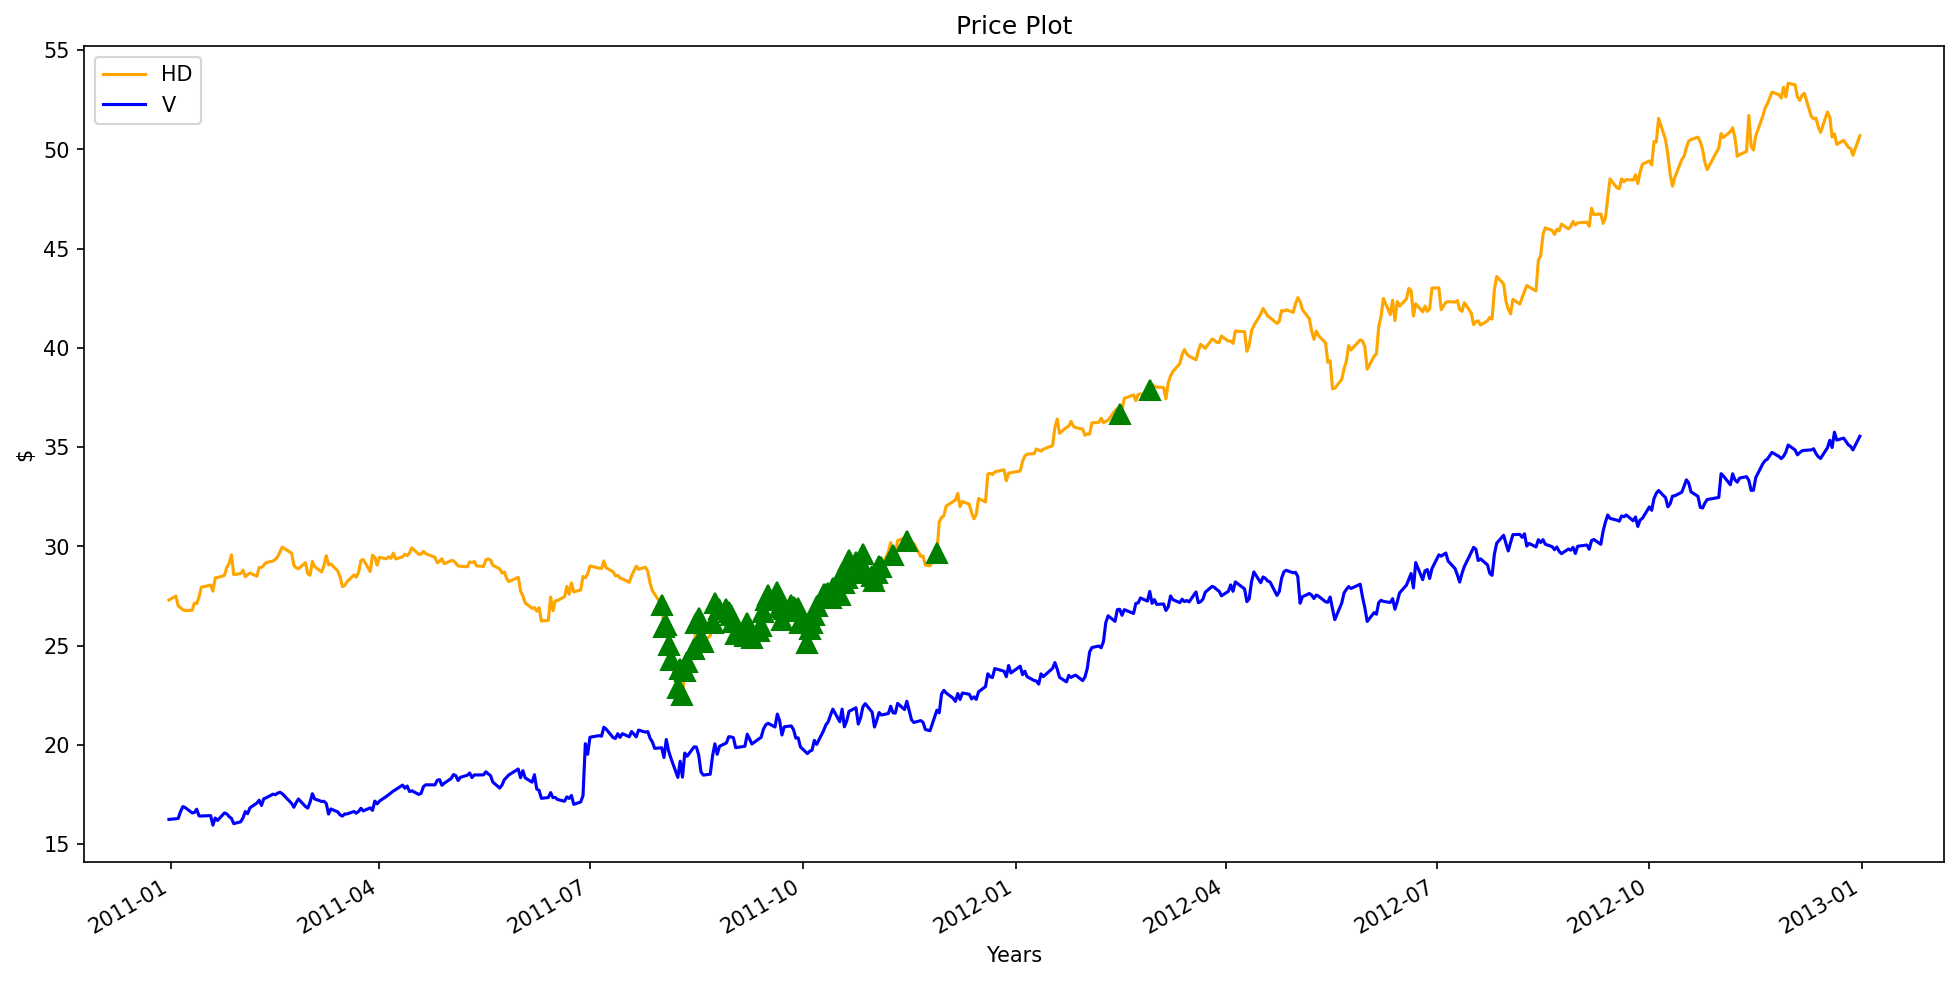

In [14]:
plt.figure(figsize=(16, 8), dpi=150)
data['HD'].plot(label = 'HD', color = "orange")
data['V'].plot(label = 'V', color = "blue")
plt.plot(buy.index, buy['Cost'], '^', markersize=10, color='g')
#data["UNH"].plot(label = "UNH", color = "red")
plt.title("Price Plot")
plt.xlabel("Years")
plt.ylabel("$")
plt.legend()

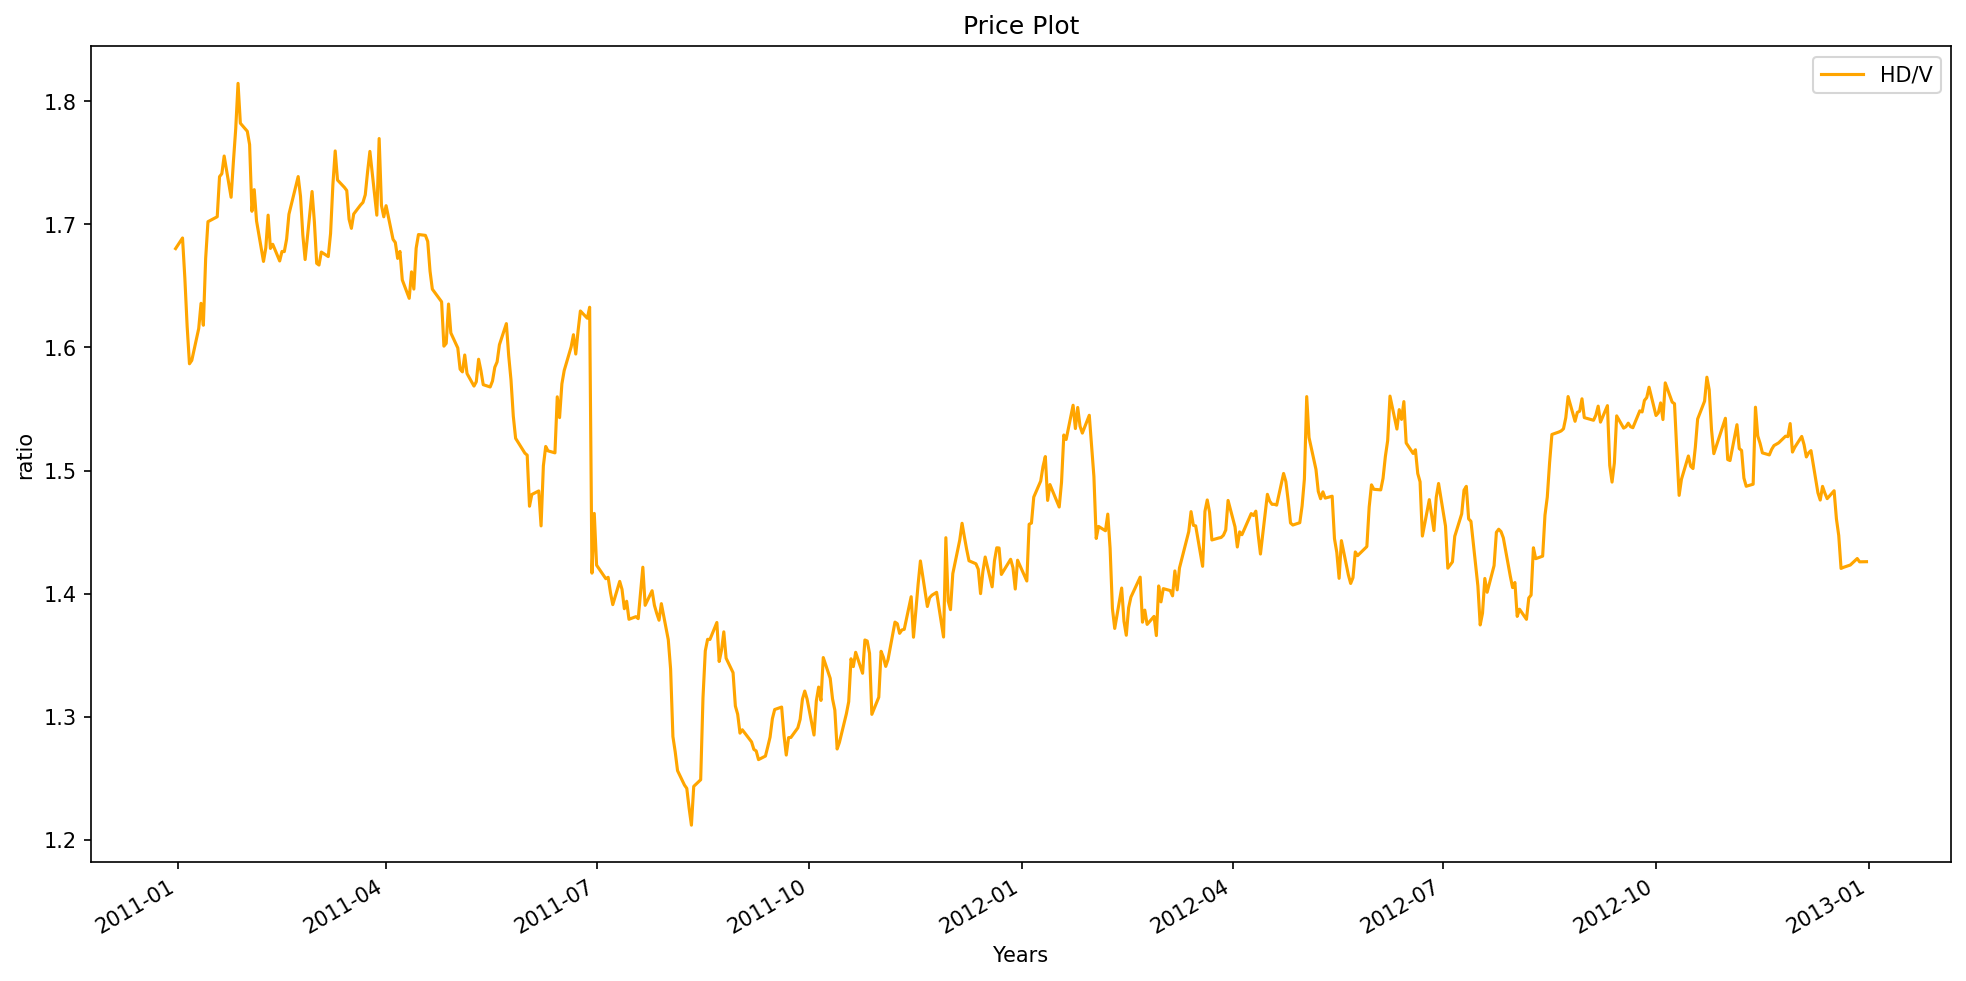

In [96]:
plt.figure(figsize=(16, 8), dpi=150)
(data['HD']/data['V']).plot(label = 'HD/V', color = "orange")
#data["UNH"].plot(label = "UNH", color = "red")
plt.title("Price Plot")
plt.xlabel("Years")
plt.ylabel("ratio")
plt.legend()